In [3]:
#!pip install scikit-image

In [4]:
import pyspark
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark PCA example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/25 10:07:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/25 10:07:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
df =  spark.read.format('csv').\
                       options(header='true', \
                       inferschema='true').\
            load("data/wine_dataset.csv",header=True);

In [6]:
df.show(5)
df.printSchema()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|style|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|  red|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|  red|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|  red|
|         11.2|            0.28|       0.56|           1.9|    0

In [7]:
labelCol='style'

In [8]:
catcols=[]
for i in df.dtypes:
    if i[1] == 'string' and i[0] != labelCol:
        catcols.append(i[0])

In [9]:
num_cols=[]
for i in df.dtypes:
    if i[1] != 'string' and i[0] != labelCol:
        num_cols.append(i[0])

In [10]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# categorical columns
categorical_columns = catcols

In [11]:
indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categorical_columns ]

In [12]:
encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(), \
                           outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers ]

In [13]:
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() \
                                       for encoder in encoders] + num_cols, outputCol="features")

In [14]:
pipeline = Pipeline(stages=indexers + encoders + [assembler])
model=pipeline.fit(df)
data = model.transform(df)
data = data.withColumn('label',col(labelCol))
data=data.select('features','label')
data.show(5, truncate=False)

+------------------------------------------------------------+-----+
|features                                                    |label|
+------------------------------------------------------------+-----+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0]  |red  |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5.0]  |red  |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5.0] |red  |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6.0]|red  |
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0]  |red  |
+------------------------------------------------------------+-----+
only showing top 5 rows



In [15]:
def findTopPrincipalComponentNumberSVD(data:pyspark.sql.dataframe.DataFrame=df, \
                                    featureCol:str='features',threshold:int=0.80) -> (int, int):
    df_detect=data.select(featureCol)
    df_detect_list=[]
    for i in df_detect.collect():
        df_detect_list.append(i[0].tolist())
    df_detect_np=np.array(df_detect_list)
    dfDotDfTranspose=np.matmul(df_detect_np, df_detect_np.transpose())
    eigen_vals, eigen_vecs = np.linalg.eig(dfDotDfTranspose) #Get list of Eigenvalues and list of Eigenvectors, 
                                                             #numbef of Eigenvalues = number of the feature columns 
    tot = sum(eigen_vals)
    var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)] #Sort the Eigenvalues in descending order
                                                                    #get the percentage of each Eigenvalue against 
                                                                    #sum of total eigenvalues
                                                                    #Then find number cumulative percentage from
                                                                    #first few largest eigenvalues to see threshold 
                                                                    #is crossed.  If so, you only need these few 
                                                                    #number of columns.
    cumulativePercept=0
    cumulativePerceptList=[]
    for i in var_exp:
        cumulativePercept+=i
        cumulativePerceptList.append(cumulativePercept)
        if cumulativePercept >= threshold:
            break
    return (len(cumulativePerceptList), float(cumulativePerceptList[-1]))

In [16]:
bestK, coveredPercentage = findTopPrincipalComponentNumberSVD(data=data, featureCol='features', threshold=0.99)

/var/folders/4q/synq9nts6dz2rwxkqkt0q8fc0000gn/T/ipykernel_913/536006574.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  return (len(cumulativePerceptList), float(cumulativePerceptList[-1]))


In [17]:
bestK

2

In [18]:
coveredPercentage

0.996437968653241

In [19]:
from pyspark import SparkContext
# $example on$
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [20]:
sc=spark.sparkContext

In [21]:
rows=data.select("features").rdd.map(lambda r: [Vectors.dense(r[:])])

In [22]:
mat = RowMatrix(rows)

In [23]:
svd = mat.computeSVD(bestK, computeU=True)

23/05/25 10:09:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/25 10:09:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


23/05/25 10:09:56 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK
23/05/25 10:09:56 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/25 10:09:56 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [24]:
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V = svd.V       # The V factor is a local dense matrix.
# $example off$
collected = U.rows.collect()
print("U factor is:")
for vector in collected:
    print(vector)
    print("Singular values are: %s" % s)
    print("V factor is:\n%s" % V)

U factor is:
[-0.0034173321965391286,0.0030835014803684197]
Singular values are: [10781.462489123822,974.2289370819723]
V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             [-4.43957536e-02,  1.97529311e-02],
             [-3.46327050e-04,  4.83046931e-04],
             [-2.49206453e-01,  9.61694534e-01],
             [-9.62685227e-01, -2.58646495e-01],
             [-6.70829335e-03,  5.44463879e-03],
             [-2.15818206e-02,  1.86868675e-02],
             [-3.45087918e-03,  3.73759909e-03],
             [-6.97381948e-02,  6.45344522e-02],
             [-3.91425090e-02,  4.15017070e-02]])
[-0.006694204979660931,0.008194087666956874]
Singular values are: [10781.462489123822,974.2289370819723]
V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             

V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             [-4.43957536e-02,  1.97529311e-02],
             [-3.46327050e-04,  4.83046931e-04],
             [-2.49206453e-01,  9.61694534e-01],
             [-9.62685227e-01, -2.58646495e-01],
             [-6.70829335e-03,  5.44463879e-03],
             [-2.15818206e-02,  1.86868675e-02],
             [-3.45087918e-03,  3.73759909e-03],
             [-6.97381948e-02,  6.45344522e-02],
             [-3.91425090e-02,  4.15017070e-02]])
[-0.0017250394083418736,0.0039663340396331615]
Singular values are: [10781.462489123822,974.2289370819723]
V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             [-4.43957536e-02,  1.97529311e-02],
             [-3.46327050e-04,  4.83046931e-04],
             [-2.49206453e-01,  9

V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             [-4.43957536e-02,  1.97529311e-02],
             [-3.46327050e-04,  4.83046931e-04],
             [-2.49206453e-01,  9.61694534e-01],
             [-9.62685227e-01, -2.58646495e-01],
             [-6.70829335e-03,  5.44463879e-03],
             [-2.15818206e-02,  1.86868675e-02],
             [-3.45087918e-03,  3.73759909e-03],
             [-6.97381948e-02,  6.45344522e-02],
             [-3.91425090e-02,  4.15017070e-02]])
[-0.0026783493057112237,0.0034484650696525714]
Singular values are: [10781.462489123822,974.2289370819723]
V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             [-4.43957536e-02,  1.97529311e-02],
             [-3.46327050e-04,  4.83046931e-04],
             [-2.49206453e-01,  9

V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             [-4.43957536e-02,  1.97529311e-02],
             [-3.46327050e-04,  4.83046931e-04],
             [-2.49206453e-01,  9.61694534e-01],
             [-9.62685227e-01, -2.58646495e-01],
             [-6.70829335e-03,  5.44463879e-03],
             [-2.15818206e-02,  1.86868675e-02],
             [-3.45087918e-03,  3.73759909e-03],
             [-6.97381948e-02,  6.45344522e-02],
             [-3.91425090e-02,  4.15017070e-02]])
[-0.01396752010201557,0.02135836387755053]
Singular values are: [10781.462489123822,974.2289370819723]
V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             [-4.43957536e-02,  1.97529311e-02],
             [-3.46327050e-04,  4.83046931e-04],
             [-2.49206453e-01,  9.616

V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             [-4.43957536e-02,  1.97529311e-02],
             [-3.46327050e-04,  4.83046931e-04],
             [-2.49206453e-01,  9.61694534e-01],
             [-9.62685227e-01, -2.58646495e-01],
             [-6.70829335e-03,  5.44463879e-03],
             [-2.15818206e-02,  1.86868675e-02],
             [-3.45087918e-03,  3.73759909e-03],
             [-6.97381948e-02,  6.45344522e-02],
             [-3.91425090e-02,  4.15017070e-02]])
[-0.011263339087501042,-0.0010251839139433633]
Singular values are: [10781.462489123822,974.2289370819723]
V factor is:
DenseMatrix([[-4.72721953e-02,  3.96272278e-02],
             [-2.06841020e-03,  1.88506370e-03],
             [-2.24024832e-03,  1.19678127e-03],
             [-4.43957536e-02,  1.97529311e-02],
             [-3.46327050e-04,  4.83046931e-04],
             [-2.49206453e-01,  9

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
uList=[]
for i in U.rows.collect():
    uList.append(i[:])
uListNP=np.array(uList)

In [26]:
uListNP.shape

(6497, 2)

In [27]:
S=np.diag(s.toArray())

In [28]:
S.shape

(2, 2)

In [29]:
US=np.matmul(uListNP,S)

In [30]:
US.shape #This is reduced dimension dataset

(6497, 2)

In [31]:
V.toArray().transpose().shape

(2, 12)

In [32]:
#You do not need to multiply with V transpose
#Unless you want to project it back to original nxm space
# USV=np.matmul(US, V.toArray().transpose()) 

In [33]:
#USV.shape

In [34]:
import pandas as pd
df_svd=spark.createDataFrame(pd.DataFrame(US))


/usr/local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [35]:
df_svd.show(3)

+-------------------+------------------+
|                  0|                 1|
+-------------------+------------------+
| -36.84383888986173|3.0040363697100134|
| -72.17331988272022| 7.982917318135894|
|-57.154060718215426|1.7232794705228514|
+-------------------+------------------+
only showing top 3 rows



In [36]:
df_svd.count()

6497

In [37]:
assembler = VectorAssembler(inputCols=df_svd.columns, outputCol="features")

In [38]:
df_svd=assembler.transform(df_svd).select("features")
df_svd.show(3, truncate=False)

+----------------------------------------+
|features                                |
+----------------------------------------+
|[-36.84383888986173,3.0040363697100134] |
|[-72.17331988272022,7.982917318135894]  |
|[-57.154060718215426,1.7232794705228514]|
+----------------------------------------+
only showing top 3 rows



In [39]:
df_label=data.select("label")

In [40]:
df_label.count()

6497

In [41]:
svdList=[]
for i in df_svd.collect():
    svdList.append(i[0])
labelList=[]
for i in df_label.collect():
    labelList.append(i[0])
combo=[(i[0],i[1]) for i in zip(svdList, labelList)]

In [42]:
spark.createDataFrame(combo, ["features","label"]).show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-36.843838889861...|  red|
|[-72.173319882720...|  red|
|[-57.154060718215...|  red|
|[-63.608467828932...|  red|
|[-36.843838889861...|  red|
|[-43.113840501597...|  red|
|[-61.913151243243...|  red|
|[-25.407051341440...|  red|
|[-21.047655722475...|  red|
|[-104.06734065693...|  red|
|[-67.627321697941...|  red|
|[-104.06734065693...|  red|
|[-62.094640157478...|  red|
|[-31.515197957117...|  red|
|[-154.05450469548...|  red|
|[-156.69820218620...|  red|
|[-109.44914011297...|  red|
|[-59.280467737853...|  red|
|[-30.825271870350...|  red|
|[-59.554637272173...|  red|
+--------------------+-----+
only showing top 20 rows



In [43]:
#!pip install scikit-image

In [44]:
from skimage.color import rgb2gray
from skimage import data
import matplotlib.pyplot as plt

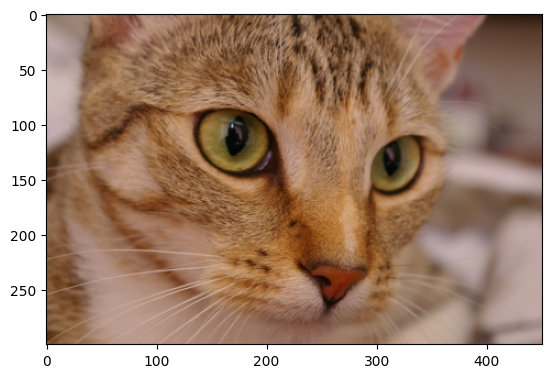

In [45]:
cat = data.chelsea()
plt.imshow(cat)
# convert to grayscale
gray_cat = rgb2gray(cat)

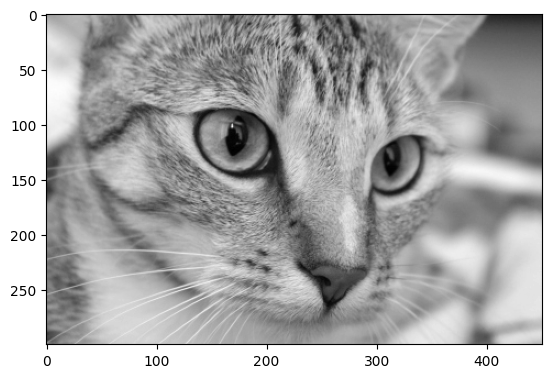

In [46]:
plt.imshow(gray_cat, cmap="gray")

In [47]:
import pandas as pd
df_cat=spark.createDataFrame(pd.DataFrame(gray_cat))

/usr/local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [48]:
from pyspark import SparkContext
# $example on$
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [49]:
sc=spark.sparkContext

In [50]:
rows=df_cat.rdd.map(lambda r: [Vectors.dense(r[:])])

In [51]:
mat = RowMatrix(rows)

In [52]:
mat

In [53]:
cols=df_cat.columns
assembler = VectorAssembler(inputCols=cols, outputCol="features")
data=assembler.transform(df_cat)
bestK, coveredPercentage = findTopPrincipalComponentNumberSVD(data=data, featureCol='features', threshold=0.99)

23/05/25 10:11:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [54]:
bestK

13

In [55]:
svd = mat.computeSVD(bestK, computeU=True)

23/05/25 10:11:21 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.


23/05/25 10:11:44 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [56]:
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V = svd.V       # The V factor is a local dense matrix.
# $example off$
collected = U.rows.collect()
print("U factor is:")
for vector in collected:
    print(vector)
    print("Singular values are: %s" % s)
    print("V factor is:\n%s" % V)

U factor is:
[-0.051696978078946756,-0.0735460780561856,0.044115300921607994,-0.05902426737827658,-0.01757105506758067,-0.12639382306681676,-0.03516866576599741,-0.06929137136314195,-0.07527055425661489,0.009573777149725253,0.09769596093605847,0.03424945973701298,-0.06634929247655334]
Singular values are: [170.4278445989755,21.64125633174394,17.393547677563337,12.39989521261162,11.540889349992801,10.220286537398998,9.124354999420389,7.391801498990899,6.852950776311915,6.631010753385142,5.550812617870085,5.202413586271814,4.996750670020012]
V factor is:
DenseMatrix([[-0.04851108, -0.13872869,  0.03622185, ..., -0.04658225,
              -0.04346458, -0.04633811],
             [-0.04826917, -0.13975339,  0.03726394, ..., -0.04003054,
              -0.03792156, -0.0397763 ],
             [-0.04809735, -0.13977431,  0.03861645, ..., -0.0371792 ,
              -0.03287068, -0.03314637],
             ...,
             [-0.0513346 ,  0.07752516,  0.00426306, ..., -0.03716693,
              -0

In [57]:
uList=[]
for i in U.rows.collect():
    uList.append(i[:])

In [58]:
uListNP=np.array(uList)

In [59]:
uListNP[0:3]

array([[-0.05169698, -0.07354608,  0.0441153 , -0.05902427, -0.01757106,
        -0.12639382, -0.03516867, -0.06929137, -0.07527055,  0.00957378,
         0.09769596,  0.03424946, -0.06634929],
       [-0.0516497 , -0.07471783,  0.04653544, -0.06638072, -0.01312483,
        -0.12573793, -0.0286743 , -0.06870357, -0.06849828,  0.0113723 ,
         0.09798175,  0.03266301, -0.07731028],
       [-0.05163224, -0.07531087,  0.05024318, -0.07533103, -0.01337699,
        -0.12442188, -0.02370785, -0.06121971, -0.06134842,  0.01150007,
         0.08855366,  0.03038112, -0.09524162]])

In [60]:
s

DenseVector([170.4278, 21.6413, 17.3935, 12.3999, 11.5409, 10.2203, 9.1244, 7.3918, 6.853, 6.631, 5.5508, 5.2024, 4.9968])

In [61]:
S=np.diag(s.array)

In [62]:
S

array([[170.4278446 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,  21.64125633,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,  17.39354768,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,  12.39989521,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         11.54088935,   0.        ,   0.        ,   0.        ,
          0.

In [63]:
US=np.matmul(uListNP,S)

In [64]:
US.shape

(300, 13)

In [65]:
USV=np.matmul(US, V.toArray().transpose())

In [66]:
USV.shape

(300, 451)

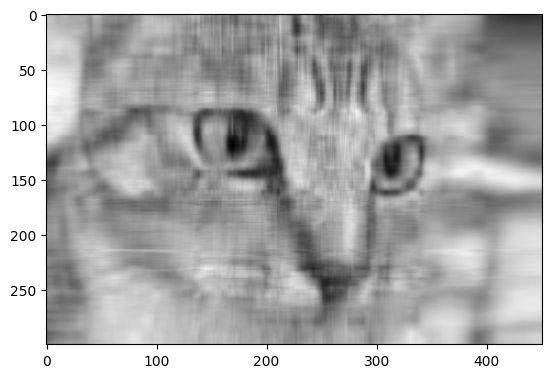

In [67]:
plt.imshow(USV, cmap="gray")

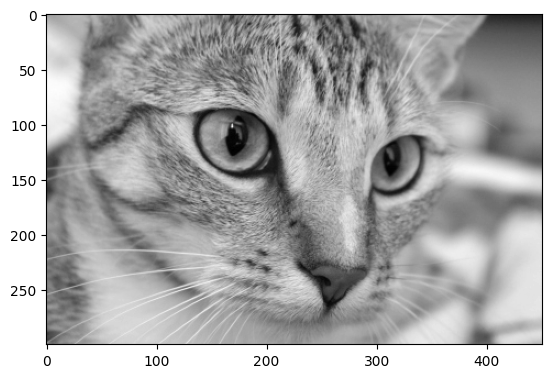

In [68]:
plt.imshow(gray_cat, cmap="gray") #Original picture

In [69]:
compressedSize=uListNP.size+s.size+V.toArray().size

In [70]:
originalSize=gray_cat.size

In [71]:
compressionRate=compressedSize/originalSize*100

In [72]:
compressionRate

7.225424981522542

In [77]:
rank=min(USV.shape[0], bestK)

In [78]:
rank

13

In [85]:
coveredPercentage

0.9905478177778588